In [71]:
%matplotlib inline

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import random
import math

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [73]:
transform_cifar = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_cifar10_full= torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_cifar)


Files already downloaded and verified


In [74]:
all_idx = list(range(0,len(train_cifar10_full)))
middle = len(all_idx) / 2
middle

25000.0

In [75]:
#this code needs to be in a function , that generates a training set and validation set from an
#input dataset and input minibatch size.  In this case, we call
#train_loader, validation_loader = function(train_cifar10_full, 32)

# p between 0 and 1, percent of data trained 
def train_val_split(train_data, minibatch_size, p):
    idx_range = list(range(0,len(train_data)))
    random.shuffle(idx_range)
    
    mid = len(idx_range)
    all_idx = list(range(0,len(train_cifar10_full)))
    random.shuffle(idx_range)
    
    middle = int(p * len(idx_range))
    #middle = len(idx_range)//2
    tr_idx = idx_range[:middle]
    val_idx = idx_range[middle:]
    
    train_subset = torch.utils.data.Subset(train_data, tr_idx)
    val_subset = torch.utils.data.Subset(train_data, val_idx)
    
    tr_loader = torch.utils.data.DataLoader(train_subset, batch_size=minibatch_size,
                                          shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=minibatch_size,
                                          shuffle=True, num_workers=2)
    return tr_loader, val_loader

# # Why 50/50 and not 80/20
# middle = len(all_idx)//2
# train_idx = all_idx[:middle]
# validation_idx = all_idx[middle:]


# train_subset = torch.utils.data.Subset(train_cifar10_full, train_idx)
# train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32,
#                                           shuffle=True, num_workers=2)

# validation_subset = torch.utils.data.Subset(train_cifar10_full, validation_idx)
# validation_loader = torch.utils.data.DataLoader(validation_subset, batch_size=32,
#                                           shuffle=True, num_workers=2)


# print(len(train_subset), len(validation_subset))

In [76]:
tr_loader, val_loader = train_val_split(train_cifar10_full, 32, 0.8)
len(val_loader)

313

In [77]:
#this stuff can be cleaned up once the above function is implemented- note that for each dataset
#we want to end up with 3 dataloaders: train, validation, and test.  Currently we don't have
#validation sets in this cell

#transform_cifar = transforms.Compose(
#    [transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_mnist = transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

train_cifar10_full= torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_cifar)

train_mnist = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform_mnist)

train_cifar10_loader = torch.utils.data.DataLoader(train_cifar10_full, batch_size=32,
                                          shuffle=True, num_workers=2)
train_mnist_loader = torch.utils.data.DataLoader(train_mnist, batch_size=32,
                                          shuffle=True, num_workers=2)

test_cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_cifar)
test_cifar10_loader = torch.utils.data.DataLoader(test_cifar10, batch_size=32,
                                         shuffle=False, num_workers=2)
test_mnist = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform_mnist)
test_mnist_loader = torch.utils.data.DataLoader(test_mnist, batch_size=32,
                                         shuffle=False, num_workers=2)

cifar10_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
mnist_classes = ('0','1','2','3','4','5','6','7','8','9')

Files already downloaded and verified
Files already downloaded and verified


In [78]:
print(train_cifar10_full)


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [79]:
#show_sample will display the first minibatch of dataloader dl
#with the first 4 images labeled according to dl_classes
def show_samples(dl, dl_classes):
    def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()


    # get some random training images
    dataiter = iter(dl)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % dl_classes[labels[j]] for j in range(4)))


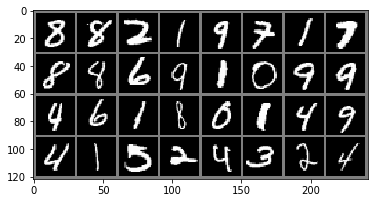

    8     8     2     1


In [80]:
show_samples(train_mnist_loader, mnist_classes)

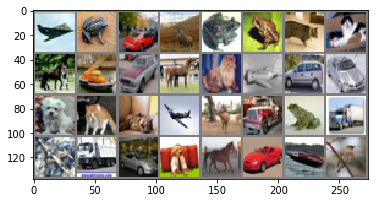

plane  frog   car  deer


In [81]:
show_samples(train_cifar10_loader, cifar10_classes)

In [82]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [83]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [84]:
print(MNISTNet())

MNISTNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [85]:
class CIFAR10Net(nn.Module):
    def __init__(self):
        super(CIFAR10Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [86]:
print('hey bud')

hey bud


In [87]:
#this one's pretty self explanatory- it runs neural net net for epochs epochs, training on the
#data in trainloader and computing training + validation accuracy after each epoch
def run_net(net, epochs, trainloader, validationloader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    train_acc_list = []
    validation_acc_list = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        #running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
#             running_loss += loss.item()
#             if i % 320 == 319:    # print every 10 mini-batches
#                 print('[%d, %5d] loss: %.3f' %
#                       (epoch + 1, i + 1, running_loss / 320)
#                 running_loss = 0.0
        train_correct = 0
        train_total = 0
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for data in trainloader:
                images, labels = data
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
            for data in validationloader:
                images, labels = data
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        train_acc = 100 * train_correct / train_total
        validation_acc = 100 * test_correct / test_total
        print('Epoch: %d Train Acc: %d%% Test Acc: %d%%' % \
              (epoch+1,train_acc,validation_acc))
        train_acc_list.append(train_acc)
        validation_acc_list.append(validation_acc)
    print('Finished Training')
    return(train_acc_list, validation_acc_list)

In [88]:
net = CIFAR10Net()
train_acc_list, validation_acc_list = run_net(net, 1, train_cifar10_loader, test_cifar10_loader)

Epoch: 1 Train Acc: 26% Test Acc: 27%
Finished Training


In [89]:
print(train_acc_list, validation_acc_list)

[26.888] [27.58]


Let's quickly save our trained model:



In [90]:
PATH = './cifar_net.pth'
PATH_MNIST = './mnist_net.pth'
torch.save(net.state_dict(), PATH_MNIST)

In [93]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

NameError: name 'testloader' is not defined

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [15]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [16]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [17]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog   dog   car horse


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 48 %
Accuracy of   car : 59 %
Accuracy of  bird : 49 %
Accuracy of   cat : 33 %
Accuracy of  deer : 49 %
Accuracy of   dog : 59 %
Accuracy of  frog : 63 %
Accuracy of horse : 59 %
Accuracy of  ship : 54 %
Accuracy of truck : 62 %


Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why dont I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

Training on multiple GPUs
-------------------------
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

Where do I go next?
-------------------

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_


